# universal estimator-exp-1c

Let $f(d)$ be a one dimensional function, that returns a samples drawn from a univariate distribution (e.g., log-normal).

**Research question**: Verify we get results as expected by Cramér–Rao bound

Let: ```search_space = [0, 1]```

1. Generate 1000 random samples (256 observations each) using $f(d)$ with d ~ uniform(search_space)
>   - d_true_array
>   - samples
2. Generate synthetic data-set ( train / test ) using $f(d)$ with d ~ uniform(search_space)
3. Fit a DNN model to the training set
>   - e = (pred_params - test_params)
>   - sigma = STD(e)
4. Predict the parameters using the DNN model
>   - d_pred_array = model.predict(samples)

5. Return:
>   - d_true_array: true parameters
>   - d_pred_array: predicted parameters

6. Let ```errors_d_pred = (d_pred_array - d_true_array)```  
   Plot the distribution of ```abs(errors_d_pred)```

**Results**:


In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=12)

In [2]:
from scipy import stats
from scipy.stats import lognorm

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

def next_config(search_space, loc=-1, scale=-1):

    """
    return a (uniform/normal) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    if loc < 0:
        return np.random.uniform(low, high, size=1)[0]
    
    param = np.random.normal(loc=loc, scale=scale, size=1)[0]

    # adjust from left
    param_adjusted = max(search_space[0], param)
    param_adjusted = max(0.01, param)
    
    # adjust from right
    param_adjusted = min(param_adjusted, search_space[1])
    
    return param_adjusted

In [3]:
def estimator_exp_1c(M = 256, N=1000):
    f = sample_lognormal
    search_space = np.array([0.0, 1.0])
    
    raw, samples, d_true_array = generate_data(N=N, 
                               M=M, 
                               sample=f, 
                               nextConfig=lambda: next_config(search_space),
                               nbins=-1,
                               density=False, 
                               apply_log_scale=False)
    
    nbins = samples.shape[1]
    
    d_pred_array = np.zeros_like(d_true_array)

    # experiment results
    res = {
        'd_true_array': d_true_array,
        'd_pred_array': d_pred_array,
    }
    
    # generate training data
    raw, H_train, train_params = generate_data(N=N, 
                                   M=M, 
                                   sample=f, 
                                   nextConfig=lambda: next_config(search_space),
                                   nbins=nbins,
                                   density=False, 
                                   apply_log_scale=False)
    
    # fit a DNN model
    print(f'training ...', end=' ')
    dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
    print('done.')

    # predict
    print(f'predicting ...', end=' ')
    d_pred_array = dnn_model.predict(samples).flatten()
    print('done.')
    
    res['d_pred_array'] = d_pred_array
    
    return res

## Fit (lognormal)

In [4]:
res = estimator_exp_1c(N=100000)

training ... done.
predicting ... done.


## Plot

MAE: 0.0433
STD: 0.0560


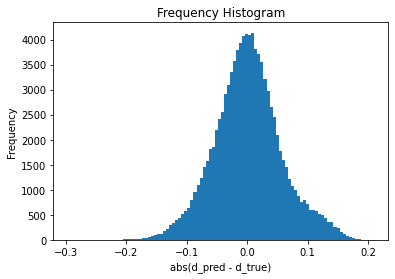

In [5]:
def plot():
    d_true_array = res['d_true_array']
    d_pred_array = res['d_pred_array']
#     errors_d_pred = np.abs(d_pred_array - d_true_array)
    e = d_pred_array - d_true_array
    
    print(f'MAE: {np.mean(np.abs(e)):.4f}')
    print(f'STD: {np.std(e):.4f}')

    plt.hist(e, bins=100)
    plt.gca().set(title='Frequency Histogram', xlabel='abs(d_pred - d_true)', ylabel='Frequency')

plot()

N = 1,000  
MAE: 0.0497  
STD: 0.0630  
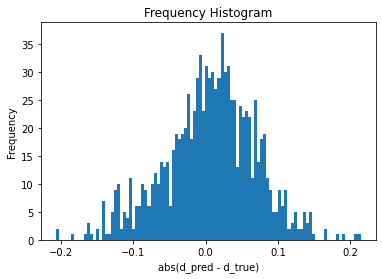

N = 10,000  
MAE: 0.0445  
STD: 0.0562  
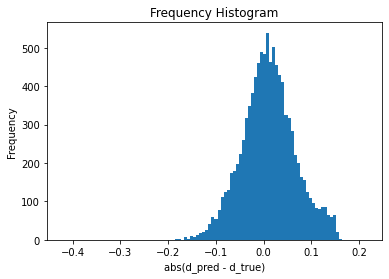

N = 100,000  
MAE: 0.0433  
STD: 0.0560  
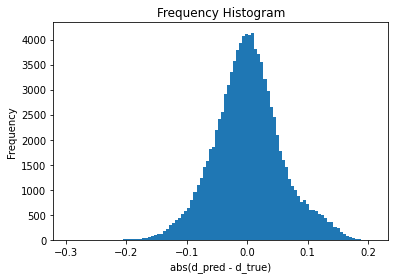
